### 데이터 불러오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 데이터 일부 확인

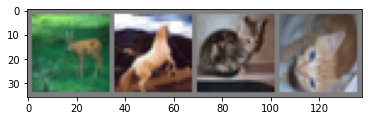

deer  horse cat   cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
print(trainset.__getitem__(0)[0].size(), trainset.__len__())
print(testset.__getitem__(0)[0].size(), testset.__len__())

torch.Size([3, 32, 32]) 50000
torch.Size([3, 32, 32]) 10000


## 모델 정의
이후부터 과제 진행하시면 됩니다! 위는 수정 XX

'#####으로 표시된 부분에 작성하세요!

In [4]:
import torch.nn as nn

In [58]:
# conv. layer, relu,  pooling layer, fc layer를 모두 1층 이상 사용하는 모델 Net()을 만들어주세요

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ##### 아래 작성 #####
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=36,kernel_size=2),             # [batch_size,3,32,32] -> [batch_size,36,31,31]
            nn.ReLU(),                
            nn.Conv2d(in_channels=36,out_channels=72,kernel_size=2,padding=1),            # [batch_size,36,31,31] -> [batch_size,72,32,32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                                # [batch_size,72,32,32] -> [batch_size,72,16,16]
            nn.Conv2d(in_channels=72,out_channels=144,kernel_size=2,padding=1),  # [batch_size,72,16,16] -> [batch_size,144,17,17]          
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                 # [batch_size,144,17,17] -> [batch_size,144,8,8]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(144*8*8,100),                                              # [batch_size,144*8*8] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                   # [batch_size,100] -> [batch_size,10]
        )


    def forward(self, x):
       ##### 아래 작성 #####
       out = self.layer(x)                                                     # self.layer에 정의한 Sequential의 연산을 차례로 수행
       out = out.view(out.size(0),-1)                                           # view 함수를 이용해 텐서를 flatten 
                                                                                # ex) 2x3 텐서를 .view(1,-1) 해주면 1x6으로, view(3,-1)이면 3x2로
                                                                                # !전체 텐서의 크기가 batch_size로 나누어 떨어지지 않으면 오류!
       out = self.fc_layer(out)

       return out


net = Net()

## 손실함수, optimizer 정의
필요한 모듈을 import하고 손실함수는 CrossEntropyLoss, optimizer는 SGD를 사용해주세요.

optimizer의 하이퍼파라미터는 lr=0.001, momentum=0.9로 통일합니다.

작성한 모델이 무거워 실행 시간이 오래 걸린다면 GPU를 활용하세요.

In [59]:
import torch.optim as optim

device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  

print(device)

model=Net().to(device)

loss_func=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

cpu


## 모델 구조 확인
필요한 모듈을 import하여 모델의 구조를 확인하세요.

In [60]:
from torchsummary import summary
summary(model,(3,32,32),batch_size = 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 36, 31, 31]             468
              ReLU-2          [256, 36, 31, 31]               0
            Conv2d-3          [256, 72, 32, 32]          10,440
              ReLU-4          [256, 72, 32, 32]               0
         MaxPool2d-5          [256, 72, 16, 16]               0
            Conv2d-6         [256, 144, 17, 17]          41,616
              ReLU-7         [256, 144, 17, 17]               0
         MaxPool2d-8           [256, 144, 8, 8]               0
            Linear-9                 [256, 100]         921,700
             ReLU-10                 [256, 100]               0
           Linear-11                  [256, 10]           1,010
Total params: 975,234
Trainable params: 975,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/

## Train

In [61]:
# 모델을 학습

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        ##### 아래 작성 #####
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss=loss_func(output,labels)
        loss.backward()
        optimizer.step() 


        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.051
[1,  4000] loss: 1.702
[1,  6000] loss: 1.537
[1,  8000] loss: 1.406
[1, 10000] loss: 1.352
[1, 12000] loss: 1.268
[2,  2000] loss: 1.157
[2,  4000] loss: 1.098
[2,  6000] loss: 1.046
[2,  8000] loss: 1.006
[2, 10000] loss: 0.981
[2, 12000] loss: 0.964
Finished Training


## Test

In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [63]:
## 아래 코드 그대로 실행

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


## 클래스별 accuracy 비교

In [64]:
## 아래 코드 그대로 실행

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 100.0 %
Accuracy for class: truck is 0.0 %
